In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import MDAnalysis as mda

from mdvcontainment import Containment
import mdvcontainment.composition_logic as cl

import warnings
warnings.filterwarnings("ignore")

In [2]:
vmd = "/Applications/VMD\ 1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh"

# Loading and voxelizing the PCD

In [3]:
# settings
settings = {}

settings['complex3D'] = ('../structures/complex3D.gro',  'name True', 1, False, False) # Artificial grid
settings['bicelle'] = ('../structures/bicelle.gro',  'name C2A C3A C4A C2B C3B C4B D2A D3A D4A D2B D3B D4B ', 0.5, True, False) # CG

# Large structures are NOT included in the git repository.
settings['transfection'] = ('../structures/large/transfection.pdb',  'name C2A C3A C4A C2B C3B C4B D2A D3A D4A D2B D3B D4B ', 0.5, True, False) # CG
settings['nanotube'] = ('../structures/large/periodic_nanotube.gro',  'resname TEST', 0.5, True, False) # AA with closing
settings['nanotube_no_closure'] = ('../structures/large/periodic_nanotube.gro',  'resname TEST', 0.5, False, False) # AA without closing
settings['mito_s10'] = ('../structures/large/mito_10_10nm_border.gro',  'not resname W WF ION', 2, False, True) # you cannot use closing with slab?

selected_settings = 'bicelle'
gro, selection_string, resolution, closing, slab= settings[selected_settings]

In [4]:
%time u = mda.Universe(gro)
selection = u.select_atoms(selection_string)

CPU times: user 255 ms, sys: 4.31 ms, total: 259 ms
Wall time: 259 ms


# Running an example

In [5]:
# Running normal mode
%time containment = Containment(selection, resolution=resolution, closing=closing, slab=slab, max_offset=0.05, write_structures=False, no_mapping=False, betafactors=True, verbose=False)

(40, 40, 40)
Writing component ids in the tempfactors of universe.
CPU times: user 1.92 s, sys: 880 ms, total: 2.8 s
Wall time: 2.81 s


In [6]:
print(containment)

Containment Graph with 3 components (component: nvoxels):
└── [-2: 59600]
    └── [1: 3868]
        └── [-1: 532]



In [7]:
# Write the processed universe to a pdb. The component labeling
#  to the betafactor in PDBs occurs in place.
%time containment.universe.atoms.write('components.pdb')

CPU times: user 312 ms, sys: 4.93 ms, total: 317 ms
Wall time: 318 ms


In [8]:
#!{vmd} components.pdb

In [9]:
filtered_nodes = {key:value for key, value in containment.voxel_containment.voxel_counts.items() if value > 20}

In [10]:
print(containment.voxel_containment.format_containment(filtered_nodes))

Containment Graph with 3 components (component: nvoxels):
└── [-2: 59600]
    └── [1: 3868]
        └── [-1: 532]



## Plot the compositions of all components
We want to obtain a nice multigraph where the colors are consistent for the labels.

Containment Graph with 3 components (component: nvoxels):
└── [-2: 59600]
    └── [1: 3868]
        └── [-1: 532]



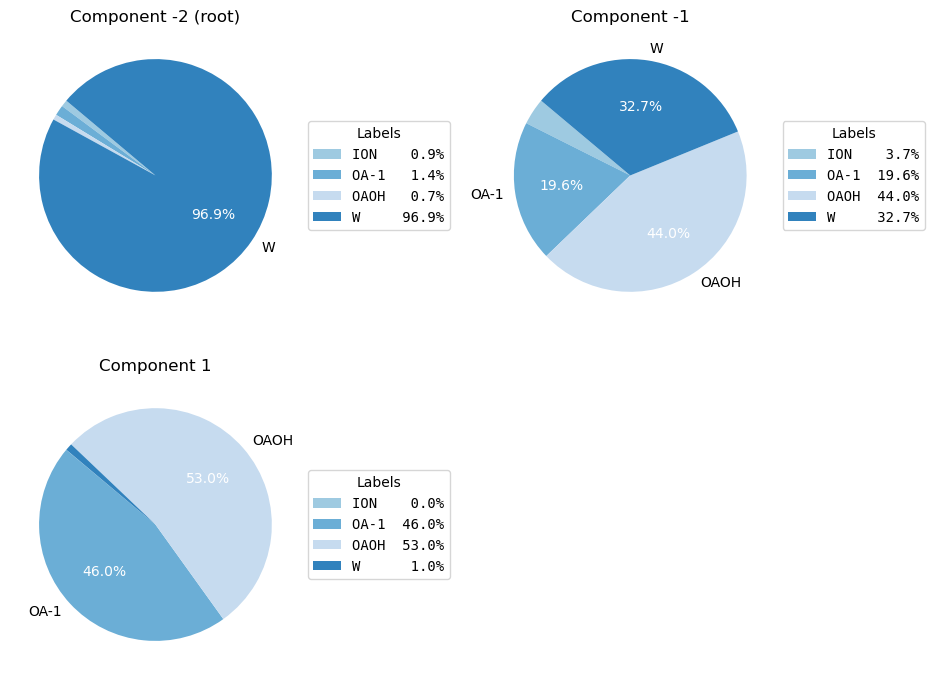

In [11]:
## Print graph one more time for easy comparison
print(containment)
## Getting the compositions
# Get all the unique component ids
nodes = containment.voxel_containment.nodes
# Obtain the compositions for the nodes
mode = 'resnames' # 'resnames, names or molar'
compositions_dict = cl.get_compositions(containment, nodes, mode)

## Setting some variable for some nice multiplotting to get it to look consistent
# Get all the unique resnames
unique_labels = cl.get_unique_labels(u, mode=mode)
# Map the unique labels to a color for consistent coloring
color_map = cl.get_color_mapping(unique_labels)
# Calculate the amount of subplots using the root 
plot_dimension = int(np.ceil(len(compositions_dict.keys())**0.5))

## Performing the mapltlib plotting
# Create the plots (the plotter can plot into supgraphs!)
scale = 4
figsize = (plot_dimension*scale,plot_dimension*scale)
fig, axs = plt.subplots(plot_dimension, plot_dimension, constrained_layout=False, figsize=figsize)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

all_keys = list(compositions_dict.keys())
root_nodes = containment.voxel_containment.root_nodes
for idx in range(plot_dimension**2):
    try:
        key = all_keys[idx]
    except IndexError:
        continue
    composition_dict = compositions_dict[key]
    
    cl.plot_pie_chart(composition_dict, axs[idx], color_map, cutoff=5)
    if key in root_nodes:
        axs[idx].set_title(f'Component {key} (root)')
    else:
        axs[idx].set_title(f'Component {key}') 
    
# Remove empty subplots
for j in range(len(all_keys), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlapping and ensure enough space for legends
plt.subplots_adjust(left=0.05, right=1.1, top=0.9, bottom=0.1, wspace=0.3)
# Show the final plot!
plt.show()

## Performing some hierarchical analysis
The goal is to select a random non_root container if there is one.
This is a rather arbitrary goal, but we hope it illustrates
how one can use a topological description to handle high
troughput data with noise. Quickly filtering interesting cases
which can be processed with more attention.

In [12]:
# Preparing the node sets for our selection
all_nodes = set(containment.voxel_containment.nodes)
root_nodes = set(containment.voxel_containment.root_nodes)
leaf_nodes = set(containment.voxel_containment.leaf_nodes)

# Select containers which are not absolute outsides. 
#  Since they contain something they cannot be a leaf node
container_nodes = list(all_nodes ^ (root_nodes | leaf_nodes))
# Shuffle the possible nodes for random selection
random.shuffle(container_nodes)
# Pick the first node in the shuffle list of possible container nodes
try:
    node = container_nodes[0]
    print(f'Selected non-root container: {node}')
except IndexError:
    print('No component satisfies the specified conditions.')

Selected non-root container: 1


In [13]:
# Get the atomgroup from the list of nodes.
visualize = False
if node is not None:
    container = containment.get_atomgroup_from_nodes([node], containment=True)
    print(f'Atomgroup with {len(container)} atoms.')
    # Write the atomgroup
    container.write('random_container.pdb')
    # Visualize with VMD
    if visualize:
        !{vmd} random_container.gro
else:
    raise ValueError('There are no non-root containers in the system.')

Atomgroup with 4902 atoms.


### Plotting the composition of the container and its contents
#### Counting the resnames in the atomgroup.atoms

In [14]:
# Get the downstream nodes to obtain the whole container.
nodes = containment.voxel_containment.get_downstream_nodes([node])

Containment Graph with 2 components (component: nvoxels):
└── [1: 3868]
    └── [-1: 532]



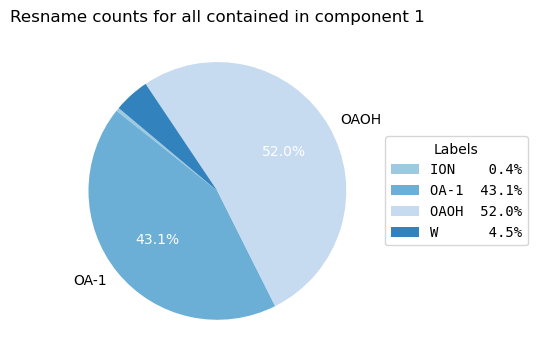

In [15]:
# Print the conainment graph selection
print(containment.voxel_containment.format_containment(nodes))
# Obtain the compositions for the nodes
compositions_dict = cl.get_compositions(containment, nodes, 'resnames')
# Combine the counts for all the compositions in the container.
composition_dict = cl.combine_dicts(compositions_dict)
# Get all the unique resnames
unique_labels = cl.get_unique_labels(u, mode='resnames')
# Map the unique labels to a color
color_map = cl.get_color_mapping(unique_labels)
# Create the plots (the plotter can plot into supgraphs!)
scale = 5
fig, ax = plt.subplots(figsize=(scale, scale))
ax.set_title(f'Resname counts for all contained in component {node}')
cl.plot_pie_chart(composition_dict, ax, color_map, cutoff=5)
# Prevent legend, figure overlap
plt.tight_layout()
# Show the final plot!
plt.show()

#### Counting the names in the atomgroup.atoms

Containment Graph with 2 components (component: nvoxels):
└── [1: 3868]
    └── [-1: 532]



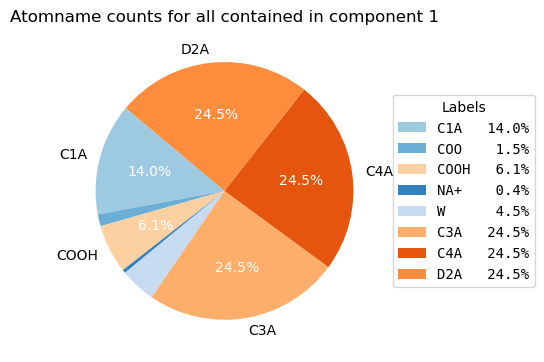

In [16]:
# Print the subselection of the containment graph.
print(containment.voxel_containment.format_containment(nodes))
# Obtain the compositions for the nodes
compositions_dict = cl.get_compositions(containment, nodes, 'names')
# Combine the counts for all the compositions in the container.
composition_dict = cl.combine_dicts(compositions_dict)
# Get all the unique resnames
unique_labels = cl.get_unique_labels(u, mode='names')
# Map the unique labels to a color
color_map = cl.get_color_mapping(unique_labels)
# Create the plots (the plotter can plot into subgraphs!)
scale = 5
fig, ax = plt.subplots(figsize=(scale, scale))
ax.set_title(f'Atomname counts for all contained in component {node}')
cl.plot_pie_chart(composition_dict, ax, color_map, cutoff=5)
# Prevent legend, figure overlap
plt.tight_layout()
# Show the final plot!
plt.show()